In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Atk-Classifier"

/content/drive/MyDrive/Atk-Classifier


In [ ]:
!pip install optuna
import os
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LassoCV
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from joblib import dump, load

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Dataset Preprocessing**

In [ ]:
# Load train dataset
df_train = pd.read_csv('dataset/train.csv')
#df_test = pd.read_csv('dataset/test.csv')

In [ ]:
class_counts = df_train['Label'].value_counts()

print(class_counts)

Label
MITM-ArpSpoofing           84260
DDoS-TCP_Flood             84208
Recon-HostDiscovery        84139
DoS-UDP_Flood              84139
DDoS-ICMP_Fragmentation    84119
DoS-TCP_Flood              84086
BenignTraffic              84085
DDoS-SYN_Flood             84051
Mirai-greip_flood          84050
DDoS-PSHACK_Flood          84047
DDoS-SynonymousIP_Flood    84021
Mirai-greeth_flood         84018
DDoS-ACK_Fragmentation     84015
DoS-SYN_Flood              83971
DDoS-RSTFINFlood           83949
DDoS-UDP_Flood             83905
DDoS-UDP_Fragmentation     83895
DNS_Spoofing               83746
Mirai-udpplain             83653
DDoS-ICMP_Flood            83587
Recon-OSScan               69603
Recon-PortScan             58311
DoS-HTTP_Flood             50629
VulnerabilityScan          26378
DDoS-HTTP_Flood            20338
DDoS-SlowLoris             16573
DictionaryBruteForce        9213
BrowserHijacking            4134
CommandInjection            3821
SqlInjection                3748
XSS 

In [ ]:
df_train.head()

,ID,flow_duration,Header_Length,Protocol type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Label
0,769866,0.000000,54.00,6.00,64.00,2.890680,2.890680,0.0,0.0,0.0,...,NaN,54.00,8.294698e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DoS-TCP_Flood
1,1859874,0.000892,54.58,NaN,64.00,28.594443,28.594443,0.0,0.0,1.0,...,0.000000,54.00,8.297298e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DoS-SYN_Flood
2,396092,0.000000,0.00,1.00,64.00,23.716061,23.716061,0.0,0.0,0.0,...,NaN,NaN,8.312478e+07,9.5,9.165151,0.000000,NaN,0.00,141.55,DDoS-ICMP_Flood
3,179708,109.146727,1992.80,8.20,50.10,41.102103,41.102103,0.0,0.0,0.0,...,305.527954,223.00,NaN,13.5,19.438032,433.145956,98347.063168,1.00,244.60,Recon-PortScan
4,1527289,0.025221,58.53,5.95,65.91,25.300629,25.300629,NaN,1.0,0.0,...,1.158718,56.76,8.334493e+07,9.5,10.420536,1.657137,61.278209,0.04,141.55,DDoS-RSTFINFlood


In [ ]:
df_train.describe()

,ID,flow_duration,Header_Length,Protocol type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
count,1.950138e+06,1.950138e+06,1.755125e+06,1.755125e+06,1.755125e+06,1.755125e+06,1.755125e+06,1.755125e+06,1.950138e+06,1.950138e+06,...,1.950138e+06,1.755125e+06,1.755125e+06,1.755125e+06,1.950138e+06,1.755125e+06,1.755125e+06,1.755125e+06,1.755125e+06,1.950138e+06
mean,1.393035e+06,5.994925e+01,2.561773e+05,1.147029e+01,7.428192e+01,6.785824e+03,6.750602e+03,8.223632e-06,4.325284e-02,1.530876e-01,...,3.476236e+02,1.691989e+02,3.476085e+02,8.328895e+07,9.497451e+00,2.172407e+01,2.389561e+02,1.435068e+05,4.054312e-01,1.414847e+02
std,8.040343e+05,9.899796e+02,8.636325e+05,1.157109e+01,2.871633e+01,8.137564e+04,8.048460e+04,8.870114e-03,2.034258e-01,3.600720e-01,...,4.437503e+02,3.121736e+02,4.445527e+02,4.192699e+07,2.013270e+00,1.445219e+01,4.411874e+02,5.795866e+05,4.360786e-01,5.183485e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.200000e+01,0.000000e+00,4.200000e+01,0.000000e+00,1.000000e+00,9.165151e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,6.966822e+05,0.000000e+00,5.400000e+01,6.000000e+00,6.400000e+01,3.076981e+00,3.073111e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,5.400000e+01,0.000000e+00,5.400000e+01,8.300794e+07,9.500000e+00,1.039230e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02
50%,1.393132e+06,7.493590e-02,1.790400e+02,6.000000e+00,6.400000e+01,2.150338e+01,2.148666e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,8.577572e+01,2.347407e+00,8.400000e+01,8.325435e+07,9.500000e+00,1.297986e+01,3.273241e+00,2.936323e+01,1.500000e-01,1.415500e+02
75%,2.089356e+06,4.271036e+00,3.354800e+04,1.645000e+01,6.670000e+01,1.334799e+02,1.332011e+02,0.000000e+00,0.000000e+00,0.000000e+00,...,5.780000e+02,2.113080e+02,5.780000e+02,8.357413e+07,9.500000e+00,3.400000e+01,2.964100e+02,7.981153e+04,9.375000e-01,1.415500e+02
max,2.785911e+06,9.968566e+04,9.905298e+06,4.700000e+01,2.550000e+02,8.388608e+06,8.388608e+06,1.170939e+01,1.000000e+00,1.000000e+00,...,1.358300e+04,1.061685e+04,1.358300e+04,1.676394e+08,1.500000e+01,1.648211e+02,1.501449e+04,1.287578e+08,1.000000e+00,2.446000e+02


In [ ]:
df_train.describe(include='object')

,Label
count,1950138
unique,34
top,MITM-ArpSpoofing
freq,84260


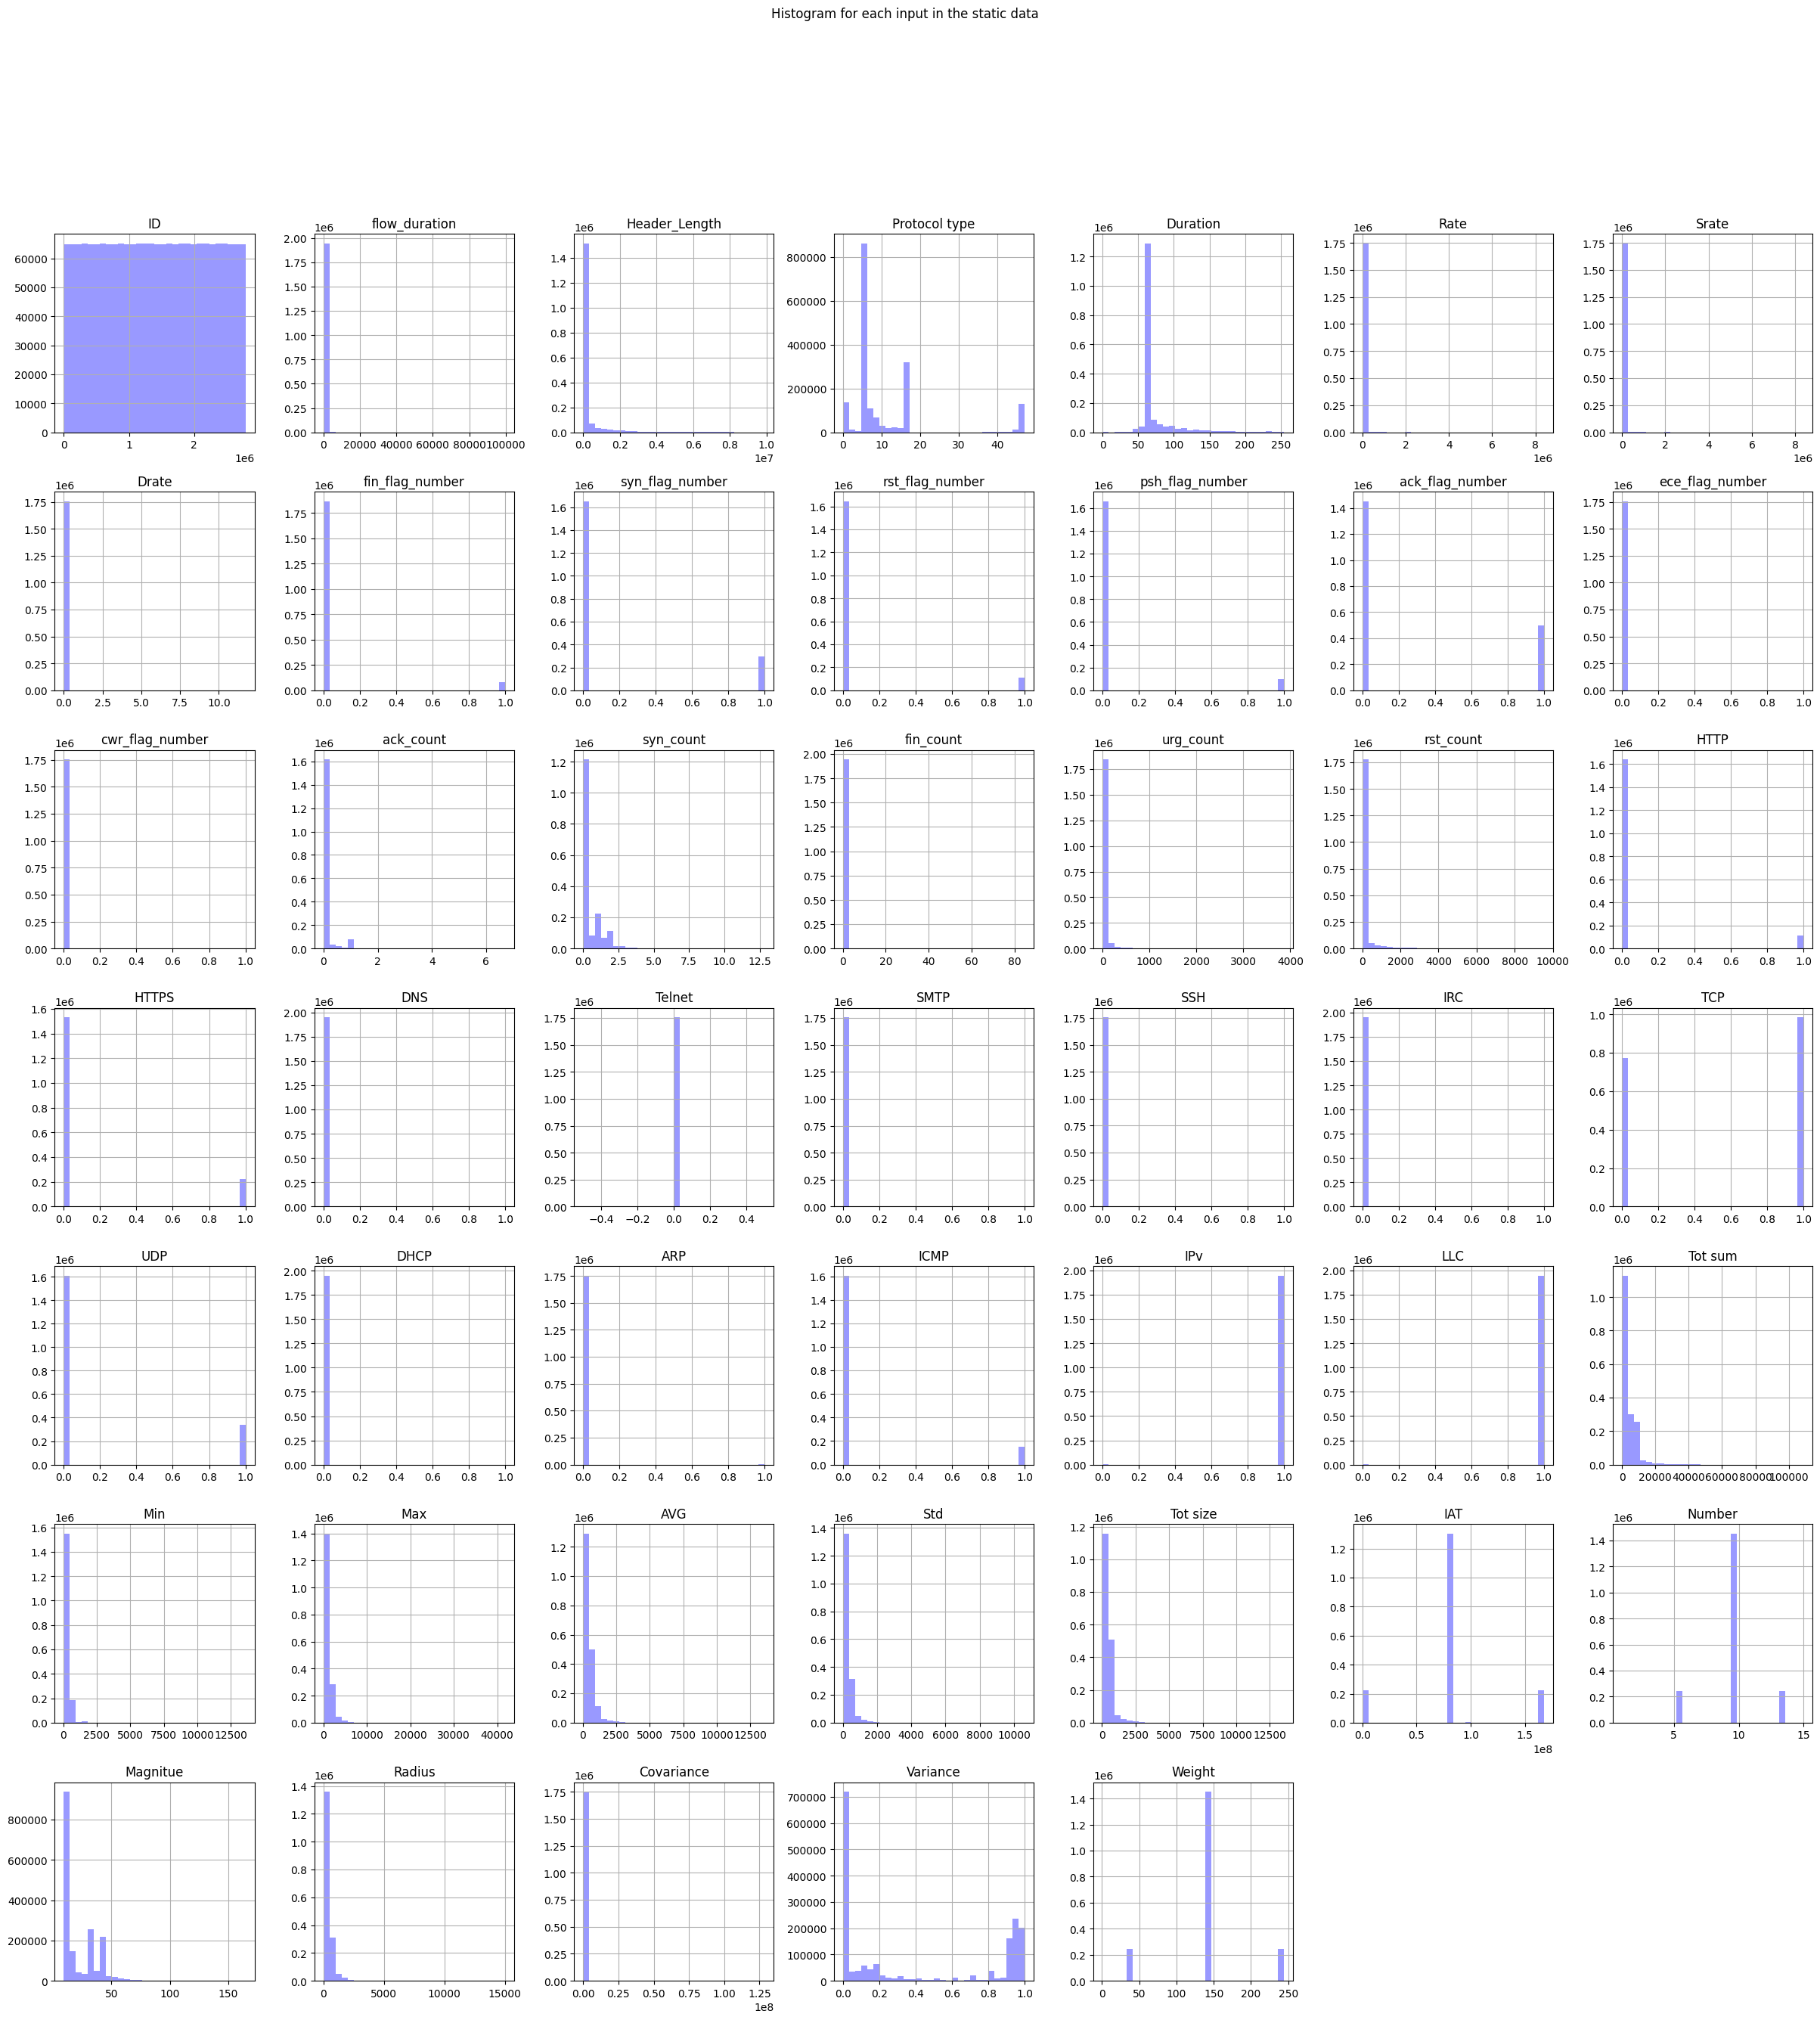

In [ ]:
# Create histograms for feature columns
df_train.hist(bins=30, figsize=(30, 30), color='blue', alpha=0.4)
plt.suptitle("Histogram for each input in the static data")
plt.show()

## **Handling Missing data**

In [ ]:
total = df_train.shape[0]
missing_columns = [col for col in df_train.columns if df_train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = df_train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

print(f"Number of duplicate rows: {df_train.duplicated().sum()}")

Header_Length: 195013 (10.0%)
Protocol type: 195013 (10.0%)
Duration: 195013 (10.0%)
Rate: 195013 (10.0%)
Srate: 195013 (10.0%)
Drate: 195013 (10.0%)
rst_flag_number: 195013 (10.0%)
psh_flag_number: 195013 (10.0%)
ece_flag_number: 195013 (10.0%)
cwr_flag_number: 195013 (10.0%)
ack_count: 195013 (10.0%)
syn_count: 195013 (10.0%)
HTTP: 195013 (10.0%)
HTTPS: 195013 (10.0%)
Telnet: 195013 (10.0%)
SMTP: 195013 (10.0%)
SSH: 195013 (10.0%)
TCP: 195013 (10.0%)
ARP: 195013 (10.0%)
ICMP: 195013 (10.0%)
Tot sum: 195013 (10.0%)
Min: 195013 (10.0%)
Max: 195013 (10.0%)
Std: 195013 (10.0%)
Tot size: 195013 (10.0%)
IAT: 195013 (10.0%)
Magnitue: 195013 (10.0%)
Radius: 195013 (10.0%)
Covariance: 195013 (10.0%)
Variance: 195013 (10.0%)
Number of duplicate rows: 0


<Axes: >

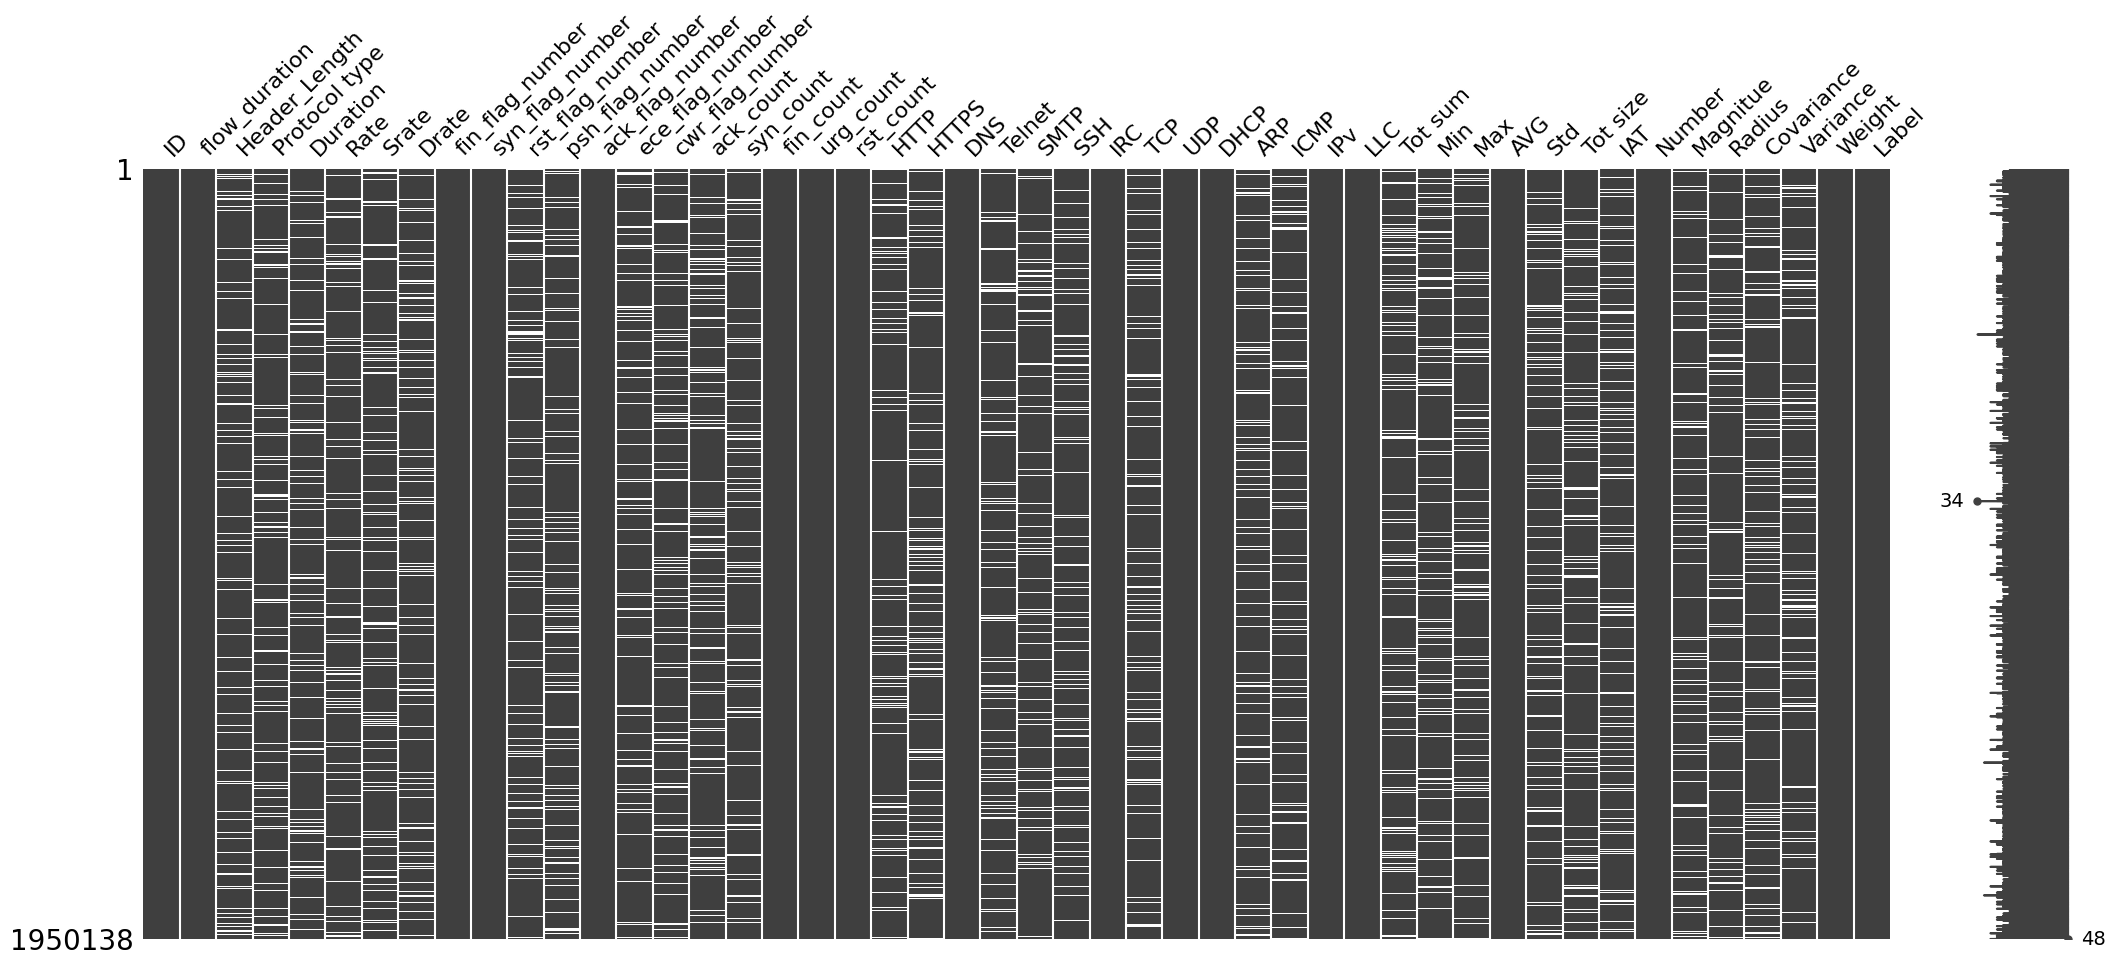

In [ ]:
import missingno as msno
msno.matrix(df_train)

In [ ]:
categorical_features = ['fin_flag_number','syn_flag_number','rst_flag_number','psh_flag_number','ack_flag_number',
                        'ece_flag_number','cwr_flag_number','HTTP','HTTPS','DNS','Telnet','SMTP','SSH','IRC','TCP',
                        'UDP','DHCP','ARP','ICMP','IPv','LLC']
numberical_features = ['flow_duration','Header_Length','Protocol type','Duration','Rate','Srate','Drate',
                       'ack_count','syn_count','fin_count','urg_count','rst_count','Tot sum','Min','Max',
                       'AVG','Std','Tot size','IAT','Number','Magnitue','Radius','Covariance','Variance']

In [ ]:
# Using Imputer
imputer = SimpleImputer(strategy='most_frequent')
df_train[categorical_features] = imputer.fit_transform(df_train[categorical_features])
#df_test[categorical_features] = imputer.transform(df_test[categorical_features])

imputer = SimpleImputer(strategy='median')
df_train[numberical_features] = imputer.fit_transform(df_train[numberical_features])
#df_test[numberical_features] = imputer.transform(df_test[numberical_features])

<Axes: >

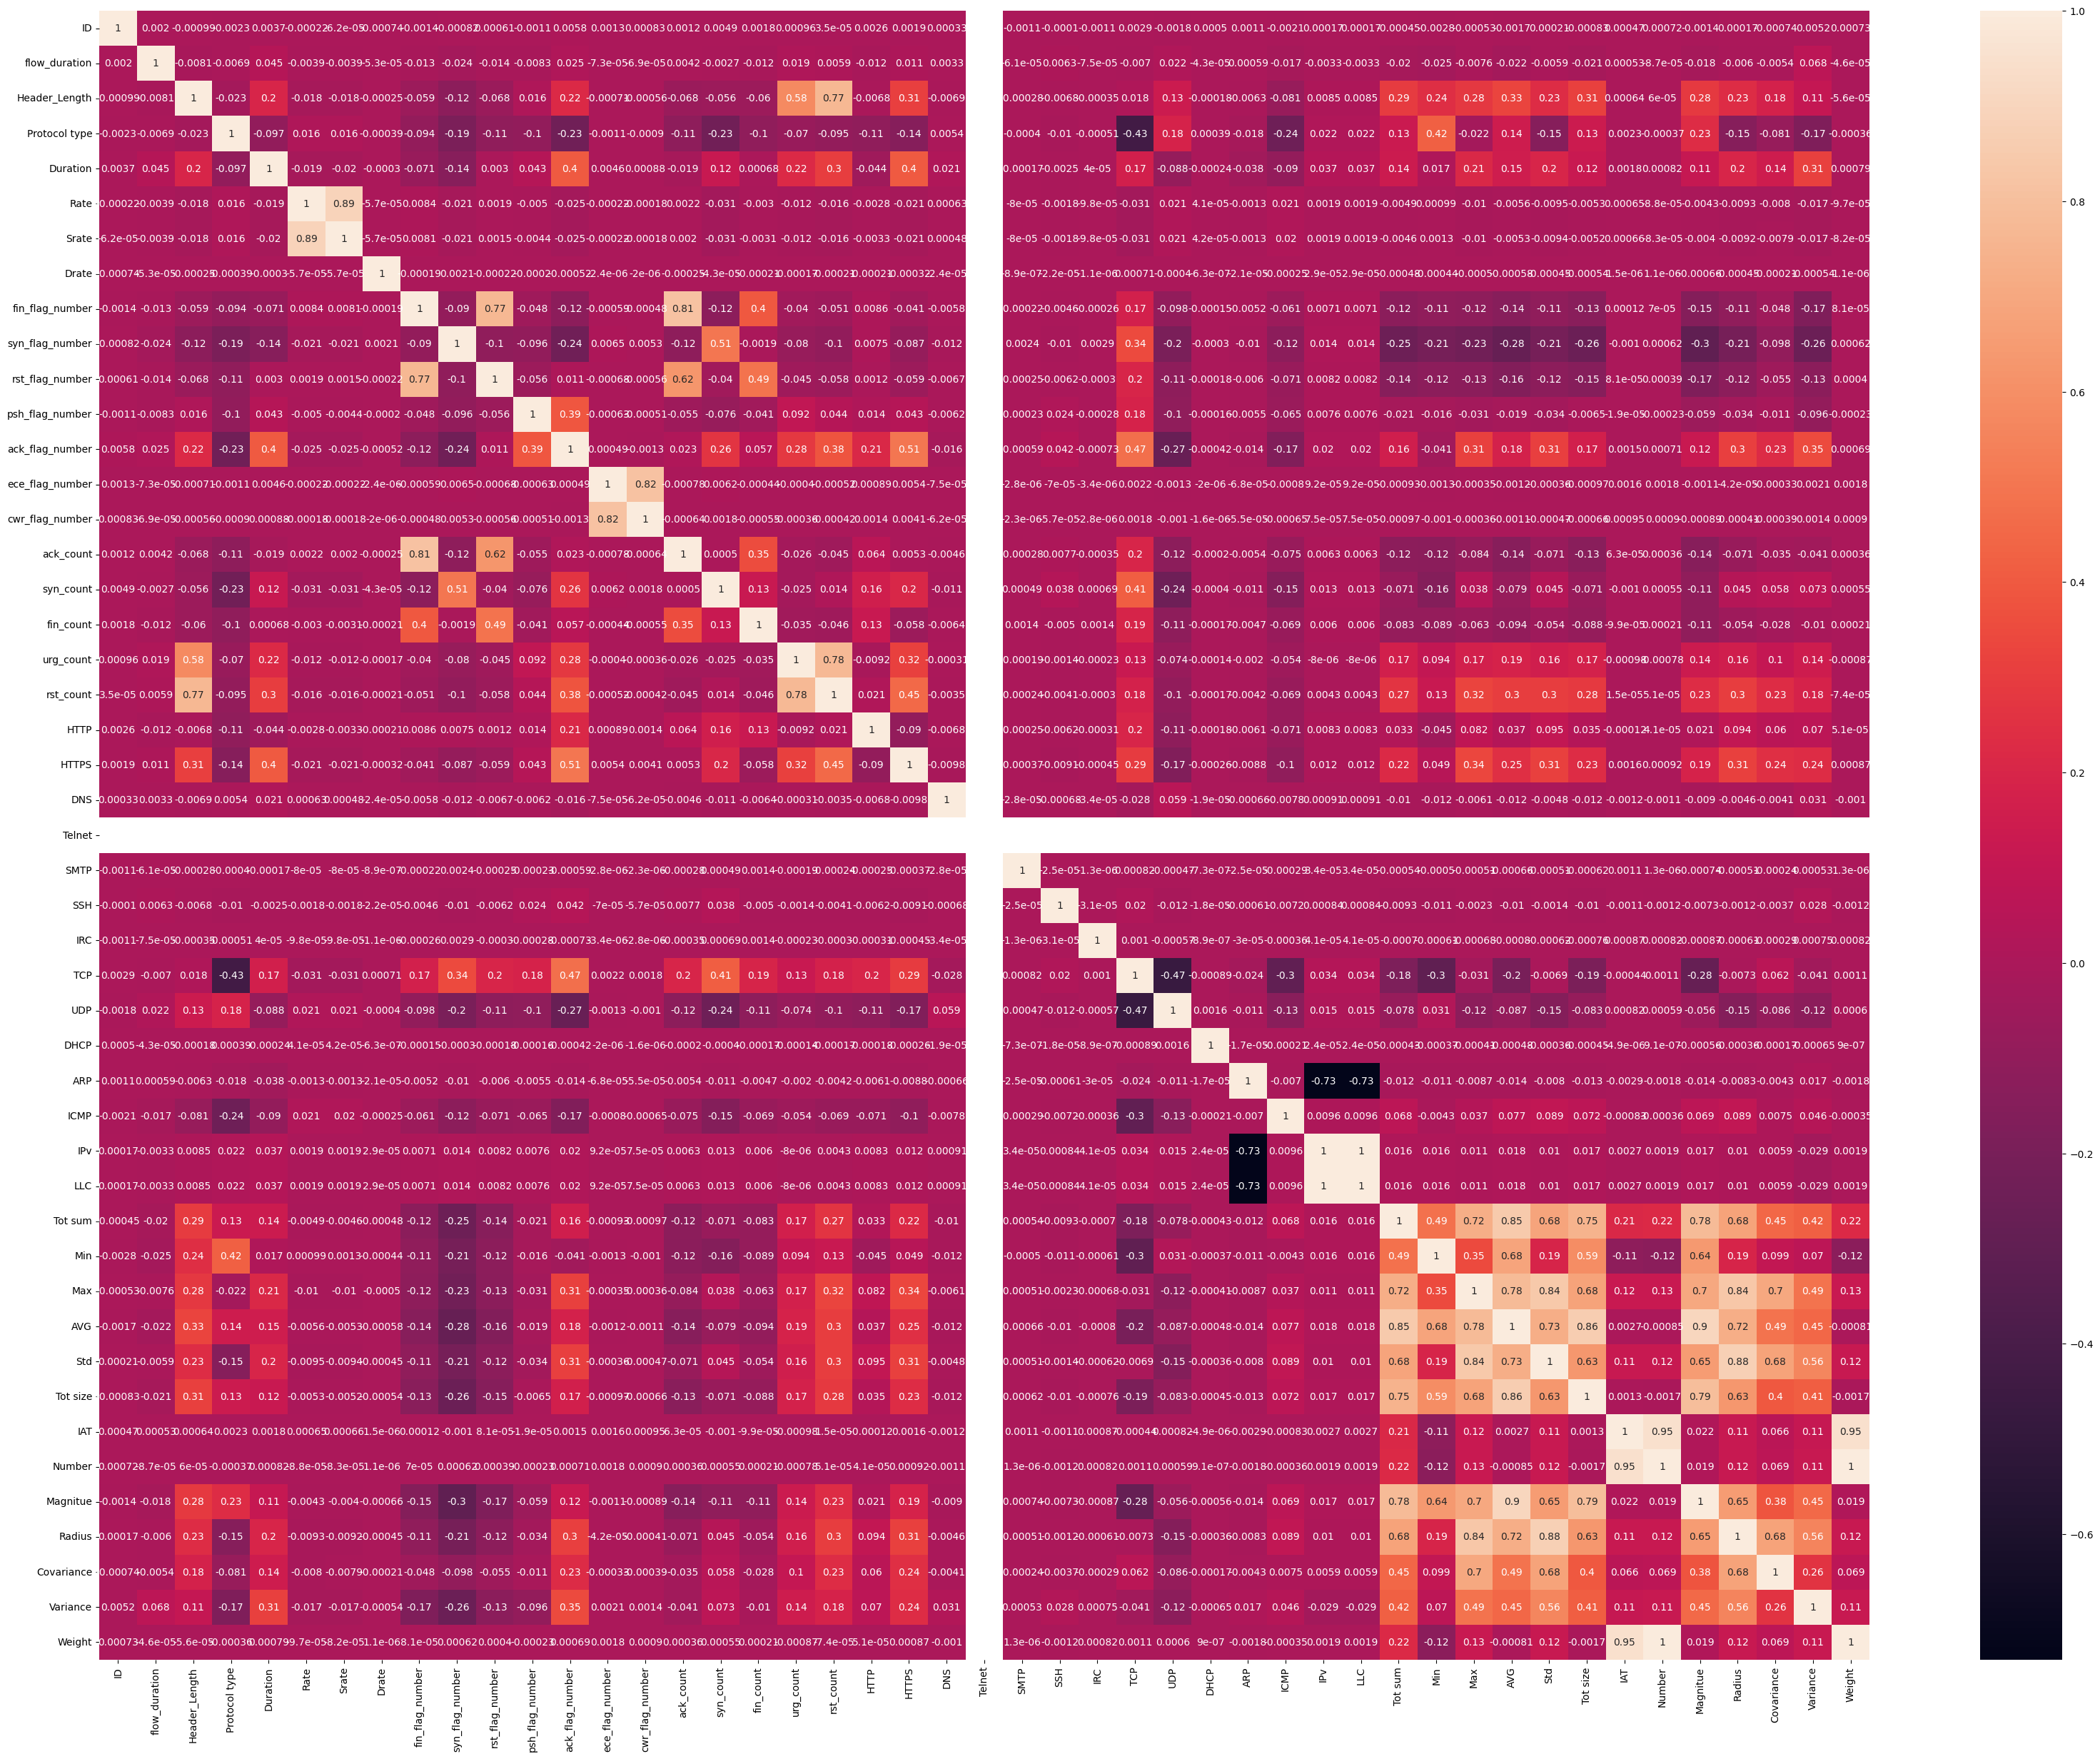

In [ ]:
plt.figure(figsize=(30,25))
sns.heatmap(df_train.drop("Label",axis=1).corr(), annot=True)

In [ ]:
df_train.to_csv('dataset/train_imputed.csv', index=False)
#df_test.to_csv('dataset/test_imputed.csv', index=False)

## **Feature Engineering**

In [ ]:
df_train = pd.read_csv('dataset/train_imputed.csv')
#df_test = pd.read_csv('dataset/test_imputed.csv')

In [ ]:
# X contains features and y contains target labels
X_train = df_train.drop(['Weight','Label'], axis=1)
y_train = df_train['Label']
sample_weights = df_train['Weight']

#X_test = df_test.drop(['Weight'], axis=1)

In [ ]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
#X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)

In [ ]:
dump(encoder, 'config/label_encoder.joblib')

['config/label_encoder.joblib']

In [ ]:
X_train.shape
#X_test.shape

(835774, 46)

In [ ]:
y_train.shape

(1950138,)

In [ ]:
# Recursive Feature Elimination
rfe = RFECV(estimator=LassoCV(), cv=5, n_jobs=-1)
# fit the model
fitted_model = rfe.fit(X_train, y_train)

In [ ]:
print('Optimal number of features: {}'.format(fitted_model.n_features_))

Optimal number of features: 31


In [ ]:
dataframe = []
rfe_selected_features = []
for i in range(X_train.shape[1]):
  if(fitted_model.support_[i] == True):
    dataframe.append([X_train.columns[i], fitted_model.ranking_[i], fitted_model.support_[i]])
    rfe_selected_features.append(X_train.columns[i])

pd.DataFrame(dataframe, columns=['Feature', 'ranking', 'selected'])

,Feature,ranking,selected
0,ID,1,True
1,flow_duration,1,True
2,Header_Length,1,True
3,Protocol type,1,True
4,Duration,1,True
5,fin_flag_number,1,True
6,syn_flag_number,1,True
7,rst_flag_number,1,True
8,psh_flag_number,1,True
9,ack_flag_number,1,True


In [ ]:
rfe_selected_features = ['ID','flow_duration','Header_Length','Protocol type','Duration',
                         'fin_flag_number','syn_flag_number','rst_flag_number','psh_flag_number',
                         'ack_flag_number','ack_count','syn_count','fin_count','urg_count',
                         'rst_count','HTTP','HTTPS','TCP','UDP','ICMP','IPv','Min','Max',
                         'AVG','Std','Tot size','Number','Magnitue','Radius','Covariance','Variance']

In [ ]:
X_train = X_train[rfe_selected_features]
#X_test = X_test[rfe_selected_features]
X_train.shape
#X_test.shape

(1950138, 31)

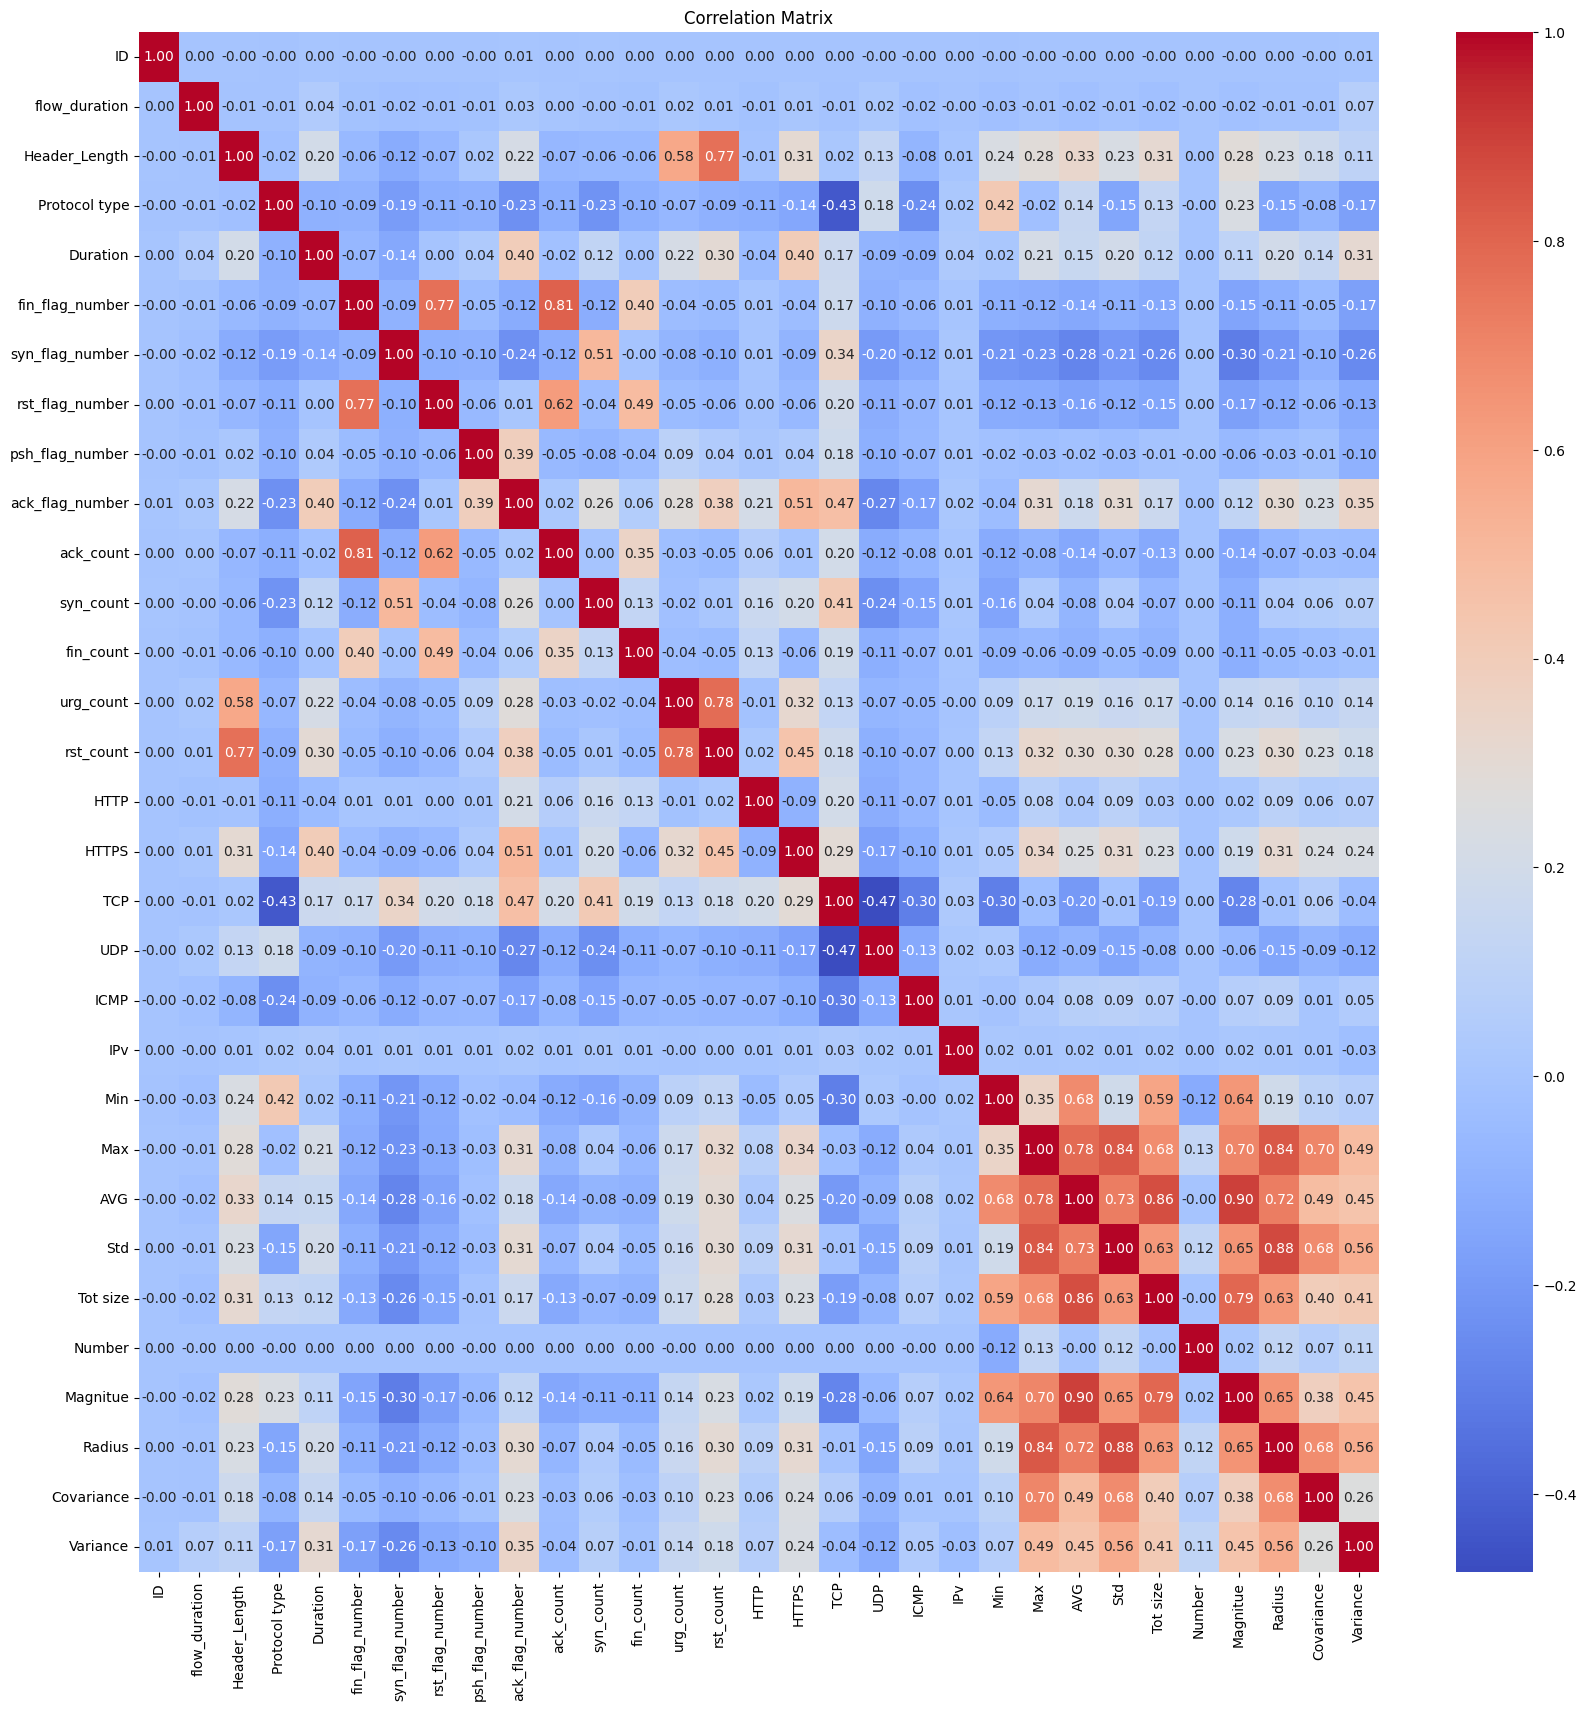

In [ ]:
corr_matrix = X_train.corr()
plt.figure(figsize=(30, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
X_train.to_csv('dataset/X_train.csv', index=False)
y_train = encoder.inverse_transform(y_train)
y_train = pd.DataFrame(y_train, columns=['Label'])
y_train.to_csv('dataset/y_train.csv', index=False)

#X_test.to_csv('dataset/X_test.csv', index=False)

## **Handling Class Imbalance**

In [ ]:
X_train = pd.read_csv('dataset/X_train.csv')
y_train = pd.read_csv('dataset/y_train.csv')

Label                  
MITM-ArpSpoofing           84260
DDoS-TCP_Flood             84208
DoS-UDP_Flood              84139
Recon-HostDiscovery        84139
DDoS-ICMP_Fragmentation    84119
DoS-TCP_Flood              84086
BenignTraffic              84085
DDoS-SYN_Flood             84051
Mirai-greip_flood          84050
DDoS-PSHACK_Flood          84047
DDoS-SynonymousIP_Flood    84021
Mirai-greeth_flood         84018
DDoS-ACK_Fragmentation     84015
DoS-SYN_Flood              83971
DDoS-RSTFINFlood           83949
DDoS-UDP_Flood             83905
DDoS-UDP_Fragmentation     83895
DNS_Spoofing               83746
Mirai-udpplain             83653
DDoS-ICMP_Flood            83587
Recon-OSScan               69603
Recon-PortScan             58311
DoS-HTTP_Flood             50629
VulnerabilityScan          26378
DDoS-HTTP_Flood            20338
DDoS-SlowLoris             16573
DictionaryBruteForce        9213
BrowserHijacking            4134
CommandInjection            3821
SqlInjection       

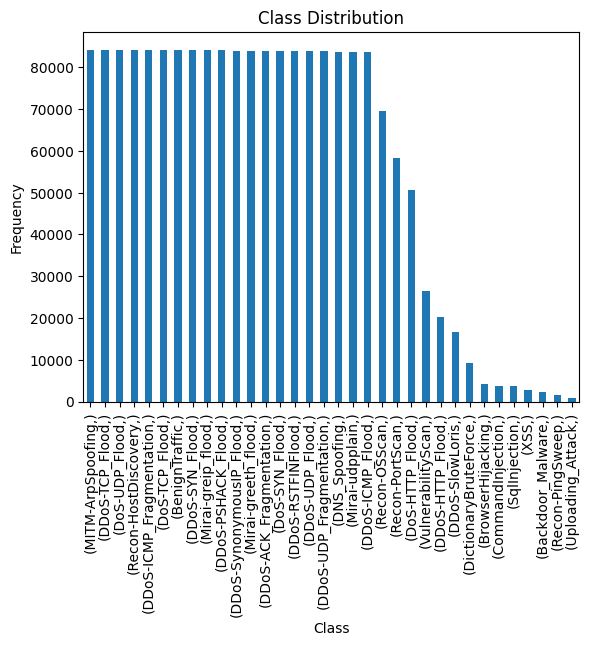

In [ ]:
class_counts = y_train.value_counts()
print(class_counts)

# Visualize the imbalance
class_counts.plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

### **SMOTE Upsampling**

In [ ]:
# Apply SMOTE to the training data
smote = SMOTE(sampling_strategy={'VulnerabilityScan':60000,
                                 'DDoS-HTTP_Flood':60000,
                                 'DDoS-SlowLoris':60000,
                                 'DictionaryBruteForce':60000,
                                 'BrowserHijacking':60000,
                                 'CommandInjection':60000,
                                 'SqlInjection':60000,
                                 'XSS':60000,
                                 'Backdoor_Malware':60000,
                                 'Recon-PingSweep':60000,
                                 'Uploading_Attack':60000}, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
X_train_smote.to_csv('dataset/X_train_preprocessed.csv', index=False)
y_train_smote.to_csv('dataset/y_train_preprocessed.csv', index=False)

### **Downsampling (Used for testing)**

In [ ]:
#df = pd.DataFrame(X_train_smote)
#df['Label'] = y_train_smote

In [ ]:
'''
downsampled_data = pd.DataFrame()

# Downsample each class
for cls in df['Label'].unique():
    class_subset = df[df['Label'] == cls]  # Filter rows for the class
    downsampled_class = resample(
        class_subset, replace=False, n_samples=50000, random_state=42
    )
    downsampled_data = pd.concat([downsampled_data, downsampled_class])

# Shuffle the dataset after downsampling
downsampled_data = downsampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
'''
X_downsampled = downsampled_data.drop(columns=['Label'])
y_downsampled = downsampled_data['Label']

In [ ]:
'''
# Check the class distribution
class_counts = y_downsampled.value_counts()
class_counts.plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

NameError: name 'y_downsampled' is not defined

In [ ]:
X_downsampled.to_csv('dataset/X_train_preprocessed.csv', index=False)
y_downsampled.to_csv('dataset/y_train_preprocessed.csv', index=False)

# **Training**

In [ ]:
encoder = load('config/label_encoder.joblib')

X_train = pd.read_csv('dataset/X_train_preprocessed.csv')
y_train = pd.read_csv('dataset/y_train_preprocessed.csv')

#X_test = pd.read_csv('dataset/X_test.csv')

## **Load & Transform Dataset**

In [ ]:
X_train = X_train.to_numpy()
#X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
y_train = encoder.transform(y_train.to_numpy().ravel())

#X_test = X_test.to_numpy()

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(2518487, 31)
(2518487,)
(835774, 31)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=42, stratify=y_train)

In [ ]:
input_dim = X_train.shape[1]
#input_dim = (X_train.shape[1], X_train.shape[2])
output_dim = len(set(y_train))

In [ ]:
print(input_dim)
print(output_dim)

31
34


## **Define the Model (PyTorch)**

In [ ]:
'''
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, dropout_rate, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
'''
'''
class DNNModel(nn.Module):
    def __init__(self, input_dim, num_classes, num_layers, hidden_dim):
        super(DNNModel, self).__init__()

        self.layers = []

        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        self.layers.append(nn.ReLU())

        # Hidden layers (dynamic based on num_layers and hidden_dim)
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.ReLU())

        # Output layer
        self.layers.append(nn.Linear(hidden_dim, num_classes))

        # Combine all layers into a sequential model
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)
'''

## **HyperParameters tuning**



In [ ]:
storage_path = "sqlite:////content/drive/MyDrive/Atk-Classifier/config/hyperparams_tuning.db"
study_name = "NID_DNN"

In [ ]:
# Objective function
def objective(trial):
    # Build the model
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(input_dim,)))  # Input layer

    # Dynamically add hidden layers
    num_layers = trial.suggest_int("num_layers", 3, 8)
    for i in range(num_layers - 1):  # All hidden layers except the last one before softmax
        num_units = trial.suggest_int(f"units_layer_{i}", 64, 512, step=64)
        model.add(keras.layers.Dense(num_units, activation="relu"))
        model.add(keras.layers.Dropout(0.1))  # Optional dropout

    # Output layer (softmax for classification)
    model.add(keras.layers.Dense(output_dim, activation="softmax"))

    # Compile the model
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Train the model
    batch_size = trial.suggest_categorical("batch_size", [64, 128])
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=batch_size,
        verbose=0,
    )

    # Evaluate the model
    score = model.evaluate(X_val, y_val, verbose=0)
    return score[1]  # Test accuracy

In [ ]:
# Create or load a study
study = optuna.create_study(study_name=study_name, storage=storage_path, load_if_exists=True, direction='maximize')

[I 2024-12-11 09:48:43,121] Using an existing study with name 'NID_DNN' instead of creating a new one.


In [ ]:
study.optimize(objective, n_trials=50)

<ipython-input-10-da358b25f623>:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2024-12-10 17:18:32,114] Trial 0 finished with value: 0.7154706120491028 and parameters: {'num_layers': 3, 'units_layer_0': 320, 'units_layer_1': 256, 'learning_rate': 0.00042871149205735777, 'batch_size': 128}. Best is trial 0 with value: 0.7154706120491028.
[I 2024-12-10 17:30:19,548] Trial 1 finished with value: 0.7508588433265686 and parameters: {'num_layers': 6, 'units_layer_0': 448, 'units_layer_1': 320, 'units_layer_2': 512, 'units_layer_3': 128, 'units_layer_4': 512, 'learning_rate': 0.0005752723630814162, 'batch_size': 64}. Best is trial 1 with value: 0.7508588433265686.
[I 2024-12-10 17:40:34,346] Trial 2 finished with value: 0.7452882528305054 and parameters: {'num

In [ ]:
# Print best hyperparameters
print(f"Best hyperparameters: {study.best_params}")

Best hyperparameters: {'num_layers': 4, 'units_layer_0': 320, 'units_layer_1': 448, 'units_layer_2': 256, 'learning_rate': 0.0009927740757552327, 'batch_size': 64}


## **Define Callback Func**

In [ ]:
class Checkpoints(Callback):
    def __init__(self, save_freq, save_path):
        super().__init__()
        self.save_freq = save_freq
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.save_path.format(epoch=epoch + 1))
            print(f"\nModel saved at epoch {epoch + 1}")

# Custom callback to save every 20 epochs
checkpoint_callback = Checkpoints(
    save_freq=20,
    save_path="models/model_epoch_{epoch:02d}.keras"
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

## **Training the Model**

In [ ]:
# Retrieve best parameters
params = study.best_params

# Rebuild the best model using the tuned hyperparameters
model = keras.Sequential()
model.add(keras.layers.Input(shape=(input_dim,)))

'''
# Add dynamically chosen layers
num_layers = params['num_layers']
for i in range(num_layers - 1):
    model.add(keras.layers.Dense(params[f'units_layer_{i}'], activation="relu"))
    model.add(keras.layers.Dropout(0.1))  # Optional dropout
'''

model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dropout(0.01))

model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dropout(0.01))

model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dropout(0.01))

# Final hidden layer and output layer
model.add(keras.layers.Dense(output_dim, activation="softmax"))

# Compile
model.compile(
    #optimizer=keras.optimizers.Adam(learning_rate=params["learning_rate"]),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Model architecture is based on hyperparameters tuning and manual testing
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 256)                 │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 34)                  │           4,386 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,826 (819.63 KB)

 Trainable params: 209,826 (819.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train on full training data
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=200,
          #batch_size=params["batch_size"],
          batch_size=128,
          callbacks=[checkpoint_callback],
          verbose=1)

Epoch 1/200
15741/15741 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.5708 - loss: 1.1407 - val_accuracy: 0.6601 - val_loss: 0.8578
Epoch 2/200
15741/15741 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.6540 - loss: 0.8706 - val_accuracy: 0.6876 - val_loss: 0.7979
Epoch 3/200
15741/15741 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.6786 - loss: 0.8152 - val_accuracy: 0.7013 - val_loss: 0.7594
Epoch 4/200
15741/15741 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.6913 - loss: 0.7852 - val_accuracy: 0.7007 - val_loss: 0.7464
Epoch 5/200
15741/15741 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.6977 - loss: 0.7672 - val_accuracy: 0.7199 - val_loss: 0.7082
Epoch 6/200
15741/15741 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.7054 - loss: 0.7491 - val_accuracy: 0.7272 - val_loss: 0.6966
Epoch 7/200
15741/15741 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.7115 - loss: 0.7356 - val_accuracy: 0.7327 - val_loss: 0.6835
Epoch 8/200
15741/15741 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - ac

KeyboardInterrupt: 

In [ ]:
# Save the trained model
model.save("models/final_model.keras")

In [ ]:
# Load to use later
model = keras.models.load_model("models/final_model.keras")

# **Evaluation**

In [ ]:
# Classification Report
y_pred = model.predict(X_val).argmax(axis=1)
print(classification_report(y_val, y_pred, target_names=encoder.classes_))

15741/15741 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step
                         precision    recall  f1-score   support

       Backdoor_Malware       0.83      0.94      0.88     12000
          BenignTraffic       0.67      0.73      0.70     16817
       BrowserHijacking       0.77      0.90      0.83     12000
       CommandInjection       0.84      0.88      0.86     12000
 DDoS-ACK_Fragmentation       0.96      0.99      0.97     16803
        DDoS-HTTP_Flood       0.91      0.89      0.90     12000
        DDoS-ICMP_Flood       1.00      1.00      1.00     16717
DDoS-ICMP_Fragmentation       0.99      0.97      0.98     16824
      DDoS-PSHACK_Flood       1.00      1.00      1.00     16809
       DDoS-RSTFINFlood       1.00      1.00      1.00     16790
         DDoS-SYN_Flood       0.57      0.87      0.69     16810
         DDoS-SlowLoris       0.95      0.95      0.95     12000
DDoS-SynonymousIP_Flood       0.88      0.68      0.76     16804
         DDoS-TCP_Flood       0.65      0.9

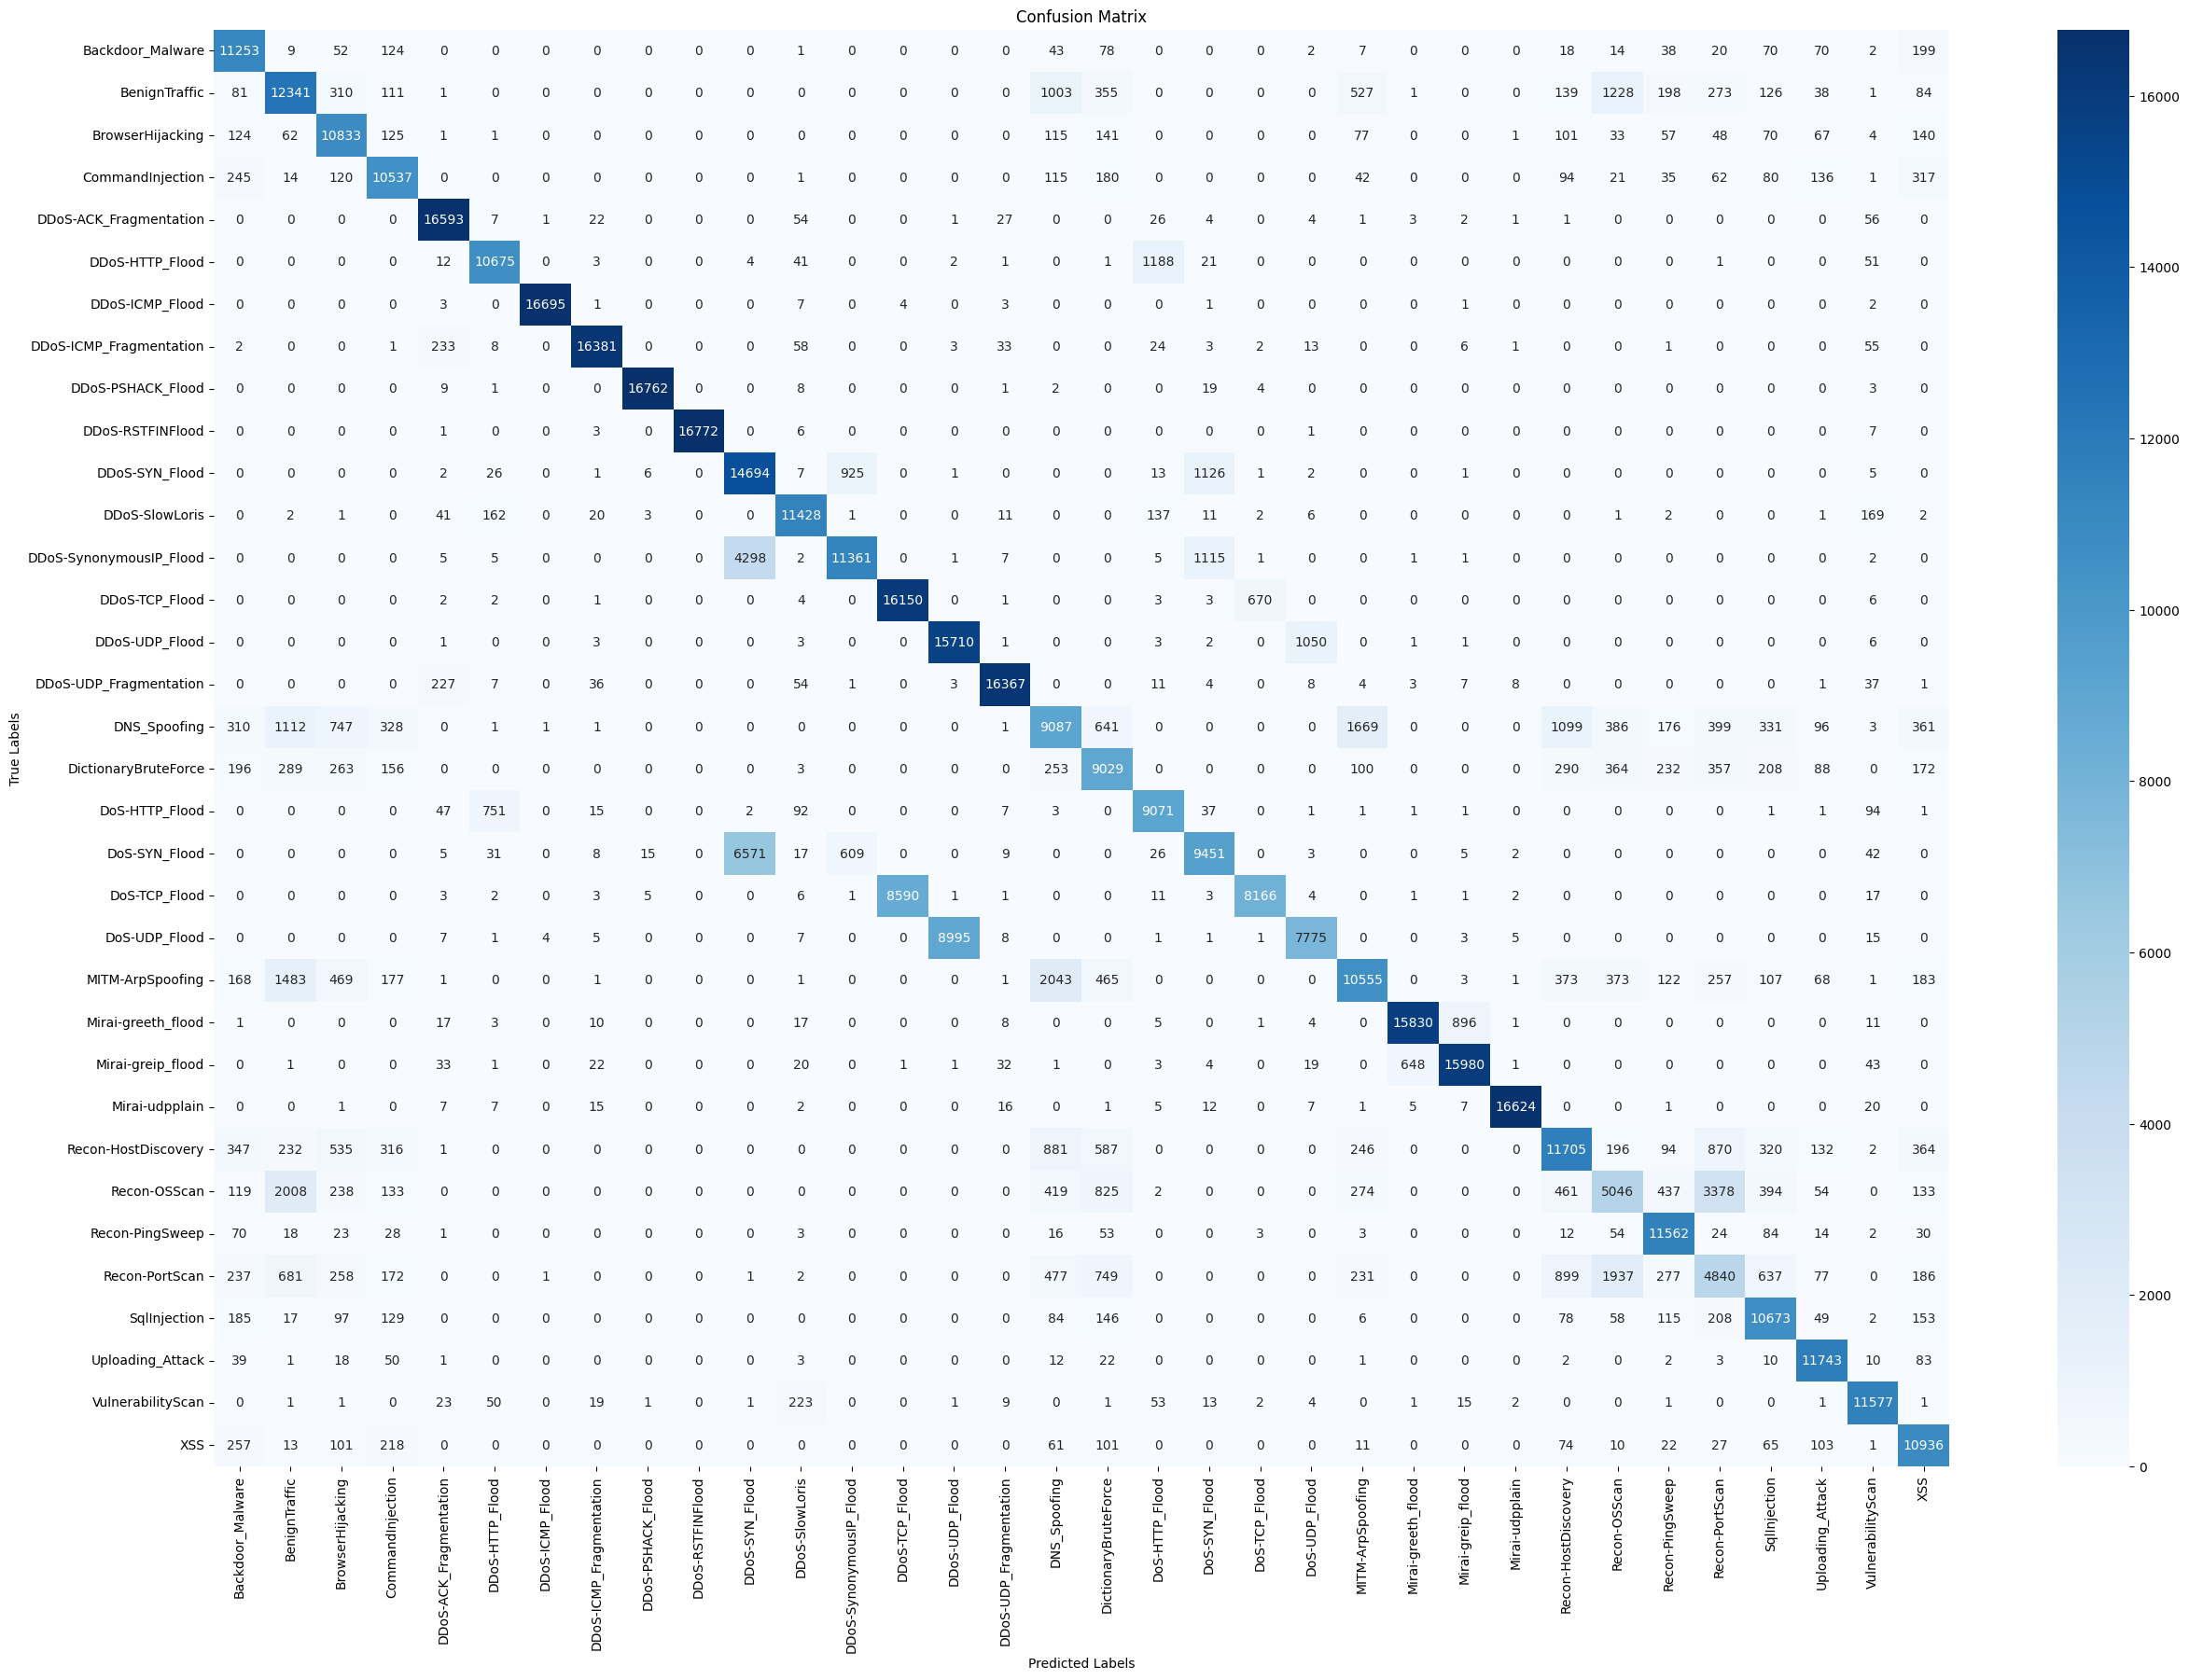

In [ ]:
cm = confusion_matrix(y_val, y_pred)

# Create a heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()